In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install dask-ml --quiet
!pip install dask --quiet
!pip install kmodes --quiet
!pip install gower --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#df_init = pd.read_csv('/content/drive/MyDrive/df_base.csv', low_memory = False)
#df_init['fecha_suceso'] = pd.to_datetime(df_init['fecha_suceso'])
iter_csv = pd.read_csv('/content/drive/MyDrive/df_base.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[ pd.to_datetime(chunk['fecha_suceso']).dt.year  >= 2016] for chunk in iter_csv])
pd.set_option('display.max_columns', None)
df.head()

,num_denuncia,fecha_suceso,hora_suceso,direccion_suceso,fecha_denuncia,delito_completado_interrumpido,nivel_ofensa,distrito,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,geoespacial,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,diff_dias_hecho_denuncia,dia_suceso,estacion_suceso,mes_suceso
0,506547392,2018-03-29,Noche,32.0,2018-03-30,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,UNKNOWN,UNKNOWN,Desconocido,"(40.810877241, -73.941064151)",25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,1,jueves,primavera,abril
1,629632833,2018-02-06,Noche,52.0,2018-02-07,COMPLETED,MISDEMEANOR,BRONX,Policia,45-64,BLACK,Femenino,"(40.873671035, -73.908013649)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,1,martes,invierno,marzo
2,787203902,2018-11-21,Madrugada,75.0,2018-11-21,COMPLETED,MISDEMEANOR,BROOKLYN,Policia,25-44,WHITE,Femenino,"(40.651782232, -73.885456761)",UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,0,miercoles,otono,diciembre
3,280364018,2018-06-09,Noche,10.0,2018-06-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,25-44,WHITE,Masculino,"(40.759310399, -73.994706072)",UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,1,sabado,verano,julio
4,985800320,2018-11-10,Noche,19.0,2018-11-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,<18,BLACK,Femenino,"(40.764535539, -73.970728388)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,0,sabado,otono,diciembre


Acotaremos el ejercicio a los distritos donde más casos hubieron

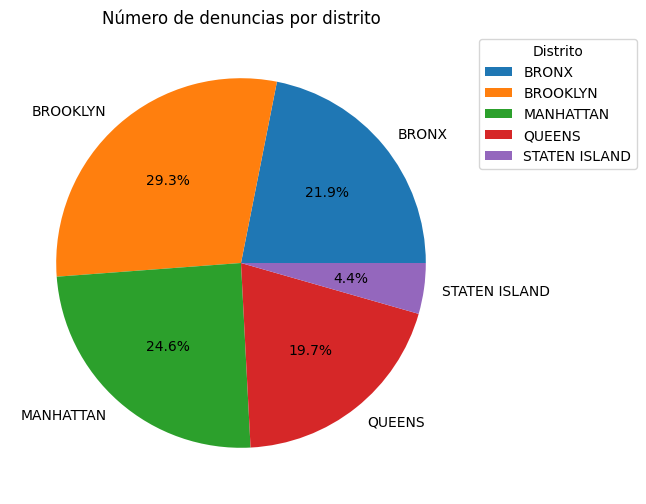

In [ ]:
distritos_counts = df.groupby(['distrito']).size()

# Crear un gráfico de torta
plt.figure(figsize=(6, 6))
distritos_counts.plot.pie(autopct='%1.1f%%')
plt.title('Número de denuncias por distrito')
plt.legend(title='Distrito', labels=distritos_counts.index, bbox_to_anchor=(1, 1))
plt.show()

## BROOKLYN

In [ ]:
df_brooklyn = df[df.distrito == 'BROOKLYN'].copy()
df_brooklyn.reset_index(inplace = True, drop = True)
df_brooklyn['direccion_suceso'] = df_brooklyn['direccion_suceso'].astype('object')

In [ ]:
df_brooklyn.drop(columns= ['fecha_suceso', 'fecha_denuncia', 'num_denuncia', 'direccion_suceso', 'distrito', 'diff_dias_hecho_denuncia', 'nivel_ofensa','delito_completado_interrumpido'], inplace = True)

Separamos coordenadas

In [ ]:
df_brooklyn['latitud'] = df_brooklyn.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[0]))
df_brooklyn['longitud'] = df_brooklyn.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[1]))
df_brooklyn.drop(columns= ['geoespacial'], inplace = True)
df_brooklyn.head()

,hora_suceso,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,latitud,longitud
0,Madrugada,Policia,25-44,WHITE,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,miercoles,otono,diciembre,40.651782,-73.885457
1,Tarde,Policia,UNKNOWN,BLACK,Desconocido,<18,BLACK,Masculino,delitos_graves,lugares publicos,martes,invierno,febrero,40.635516,-73.913278
2,Noche,Policia,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,lugares publicos,miercoles,otono,diciembre,40.671535,-73.961948
3,Tarde,Policia,UNKNOWN,WHITE,Femenino,25-44,WHITE,Masculino,incidentes_menores,lugares publicos,martes,verano,agosto,40.579353,-73.980497
4,Madrugada,Policia,UNKNOWN,ASIAN / PACIFIC ISLANDER,Masculino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares solitarios,domingo,invierno,febrero,40.610565,-74.010396


In [ ]:
from sklearn.preprocessing import MinMaxScaler
num_cols = df_brooklyn.select_dtypes('number')
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(num_cols), columns = num_cols.columns.tolist())
df_brooklyn_ready = pd.concat([df_brooklyn.drop(columns = num_cols.columns.tolist()), scaled], axis = 1)
df_brooklyn_ready_sample = df_brooklyn_ready.sample(frac = 0.05, replace = True, random_state=1234)

## **1ra iteración:** de 2016 a 2019
- Sin reducción de de dimensionalidad y aplicación de KMeans y Spectral Clustering.

## **2da iteración:** De 2016 a 2019 y distrito con mayor número de casos
- Sin reducción de dimensionalidad y KModes.

### 1.1 Sin reducción de dimensionalidad y aplicación de KMeans.

Método del codo

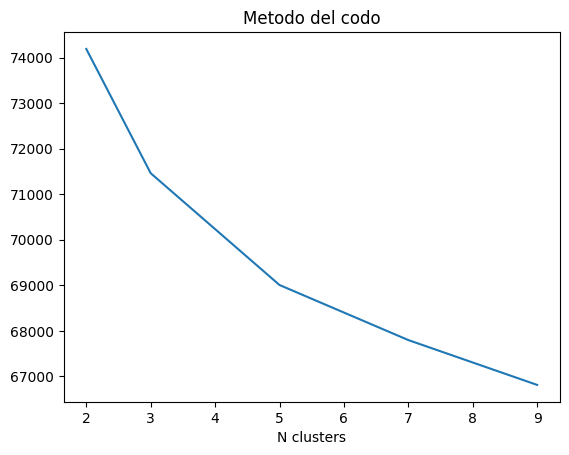

In [ ]:
from sklearn.metrics import silhouette_score  
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
sample = df_brooklyn_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()


In [ ]:
from sklearn import metrics
sample = df_brooklyn_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
metrics_df_general = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(X, labels)
  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(X, labels)
  metrics_df = pd.DataFrame({'Metodo': ['KMeans'],
                           'k':[k],
                           'Calinski-Harabasz Index': [ch_score],
                           'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general = metrics_df_general.append(metrics_df, ignore_index=True)
metrics_df_general

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans,2,3214.809666,0.101131
1,KMeans,3,2627.229091,0.103900
2,KMeans,5,1961.062258,0.087516
3,KMeans,7,1368.699842,0.075553
4,KMeans,9,1249.444090,0.064177


### Centroides con KMeans y clusters igual a 3

In [ ]:
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
dummies = pd.get_dummies(df_brooklyn_ready)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
kmeans = KMeansDask(n_clusters=3, random_state=1234)
kmeans.fit(X)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 


In [ ]:
centroides_brooklyn = pd.DataFrame(centroids, columns = pd.get_dummies(df_brooklyn_ready_sample).columns.tolist())
centroides_brooklyn.reset_index(inplace = True, drop = False)
centroides_brooklyn.rename(columns = {'index':'cluster'}, inplace =True)
centroides_brooklyn

,cluster,latitud,longitud,hora_suceso_Madrugada,hora_suceso_Mañana,hora_suceso_Noche,hora_suceso_Tarde,jurisdiccion_encargada_Externas,jurisdiccion_encargada_Otras,jurisdiccion_encargada_Policia,jurisdiccion_encargada_Transito,jurisdiccion_encargada_Vivienda,grupo_edad_sospechoso_25-44,grupo_edad_sospechoso_45-64,grupo_edad_sospechoso_<18,grupo_edad_sospechoso_UNKNOWN,raza_sospechoso_AMERICAN INDIAN/ALASKAN NATIVE,raza_sospechoso_ASIAN / PACIFIC ISLANDER,raza_sospechoso_BLACK,raza_sospechoso_UNKNOWN,raza_sospechoso_WHITE,sexo_sospechoso_Desconocido,sexo_sospechoso_Femenino,sexo_sospechoso_Masculino,grupo_edad_victima_25-44,grupo_edad_victima_45-64,grupo_edad_victima_<18,grupo_edad_victima_UNKNOWN,raza_victima_AMERICAN INDIAN/ALASKAN NATIVE,raza_victima_ASIAN / PACIFIC ISLANDER,raza_victima_BLACK,raza_victima_UNKNOWN,raza_victima_WHITE,sexo_victima_Femenino,sexo_victima_Masculino,sexo_victima_Transgenero,tipo_crimen_armas_drogas,tipo_crimen_crimenes_sexuales,tipo_crimen_delitos_graves,tipo_crimen_extorsion,tipo_crimen_incidentes_menores,tipo_crimen_otros_crimenes,lugar_Otros,lugar_diversion y turismo,lugar_lugares publicos,lugar_lugares solitarios,lugar_necesidades diarias,dia_suceso_domingo,dia_suceso_jueves,dia_suceso_lunes,dia_suceso_martes,dia_suceso_miercoles,dia_suceso_sabado,dia_suceso_viernes,estacion_suceso_invierno,estacion_suceso_otono,estacion_suceso_primavera,estacion_suceso_verano,mes_suceso_abril,mes_suceso_agosto,mes_suceso_diciembre,mes_suceso_febrero,mes_suceso_julio,mes_suceso_junio,mes_suceso_marzo,mes_suceso_mayo,mes_suceso_noviembre,mes_suceso_octubre,mes_suceso_septiembre
0,0,0.274280,0.504826,0.169556,0.205539,0.302244,0.322661,0.000120,0.007869,0.913715,0.018066,0.060230,0.001385,0.000731,0.000748,0.997136,0.000158,0.001192,0.010322,0.984289,0.004039,0.941847,0.019626,0.038526,0.367342,0.205214,0.035154,0.392290,0.005663,0.067902,0.318814,0.280314,0.327307,0.347955,0.423371,0.228675,0.036047,0.071693,0.071334,0.560115,0.242621,0.018190,0.037539,0.126243,0.750049,0.038501,0.047669,0.127602,0.144920,0.141958,0.143527,0.145587,0.137928,0.158478,0.232137,0.255917,0.243232,0.268714,0.078737,0.091606,0.161388,0.082250,0.086665,0.086490,0.069876,0.078006,0.086934,0.087605,0.090443
1,1,0.244530,0.465559,0.179764,0.182378,0.308519,0.329340,0.000046,0.005861,0.921822,0.016997,0.055274,0.460315,0.171178,0.038286,0.330221,0.007466,0.087029,0.000000,0.053026,0.852478,0.011658,0.209152,0.779189,0.354721,0.170252,0.048000,0.427028,0.006017,0.079086,0.093707,0.309307,0.511883,0.418828,0.315004,0.266169,0.082920,0.251585,0.213922,0.214133,0.179387,0.058053,0.026756,0.150320,0.749213,0.033645,0.040066,0.144082,0.144064,0.131626,0.138203,0.143826,0.150338,0.147861,0.232341,0.249172,0.257189,0.261298,0.084433,0.086754,0.154099,0.080801,0.086139,0.088653,0.075738,0.084103,0.086451,0.084424,0.088405
2,2,0.285604,0.530877,0.154229,0.199822,0.309194,0.336756,0.000040,0.008126,0.830492,0.028042,0.133300,0.418607,0.146985,0.059358,0.375050,0.000852,0.005058,0.975121,0.018969,0.000000,0.016533,0.242221,0.741246,0.351268,0.172330,0.059990,0.416411,0.003163,0.031887,0.549370,0.283713,0.131866,0.466320,0.286275,0.247405,0.063053,0.239840,0.237464,0.250242,0.154570,0.054832,0.031837,0.139405,0.740990,0.031015,0.056752,0.135290,0.142268,0.138999,0.143772,0.148333,0.142659,0.148679,0.229939,0.251244,0.249420,0.269396,0.080608,0.091492,0.155041,0.080558,0.086885,0.089080,0.072663,0.079731,0.086534,0.086388,0.091020


In [ ]:
brooklyn_kmeans_sin_reduccion = df_brooklyn_ready.copy()
brooklyn_kmeans_sin_reduccion['clusters'] = kmeans.labels_

### Análisis de clusters en KMeans sin reducción

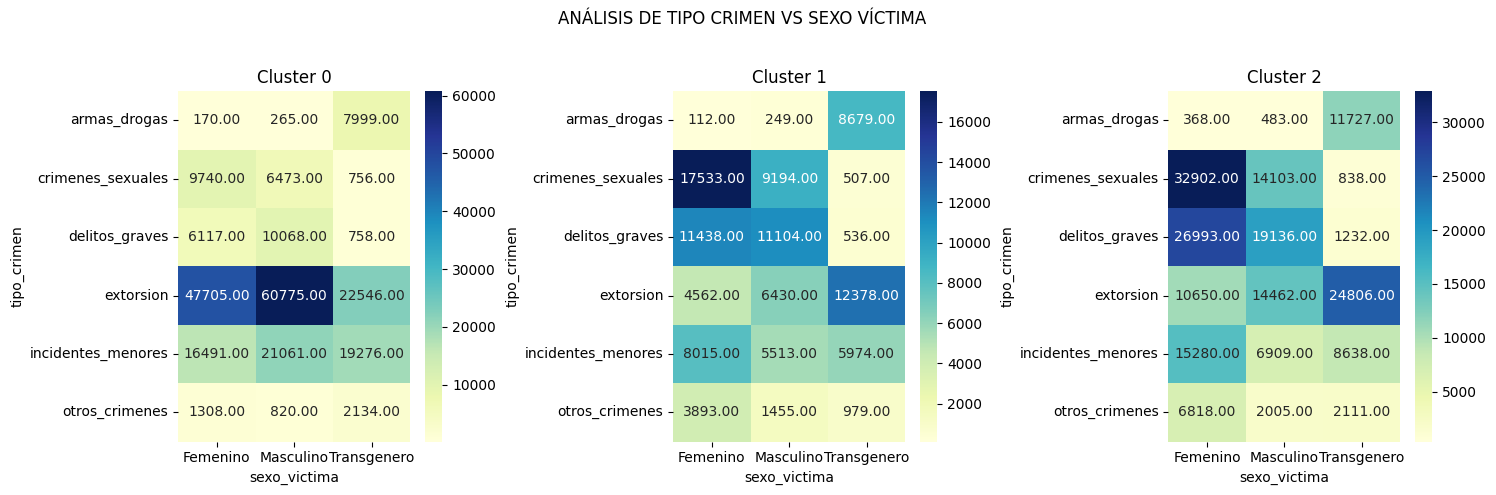

In [ ]:
brooklyn_cluster0 = brooklyn_kmeans_sin_reduccion[brooklyn_kmeans_sin_reduccion['clusters']==0]
brooklyn_cluster1 = brooklyn_kmeans_sin_reduccion[brooklyn_kmeans_sin_reduccion['clusters']==1]
brooklyn_cluster2 = brooklyn_kmeans_sin_reduccion[brooklyn_kmeans_sin_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster0['tipo_crimen'], brooklyn_cluster0['sexo_victima'])
ct1 = pd.crosstab(brooklyn_cluster1['tipo_crimen'], brooklyn_cluster1['sexo_victima'])
ct2 = pd.crosstab(brooklyn_cluster2['tipo_crimen'], brooklyn_cluster2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

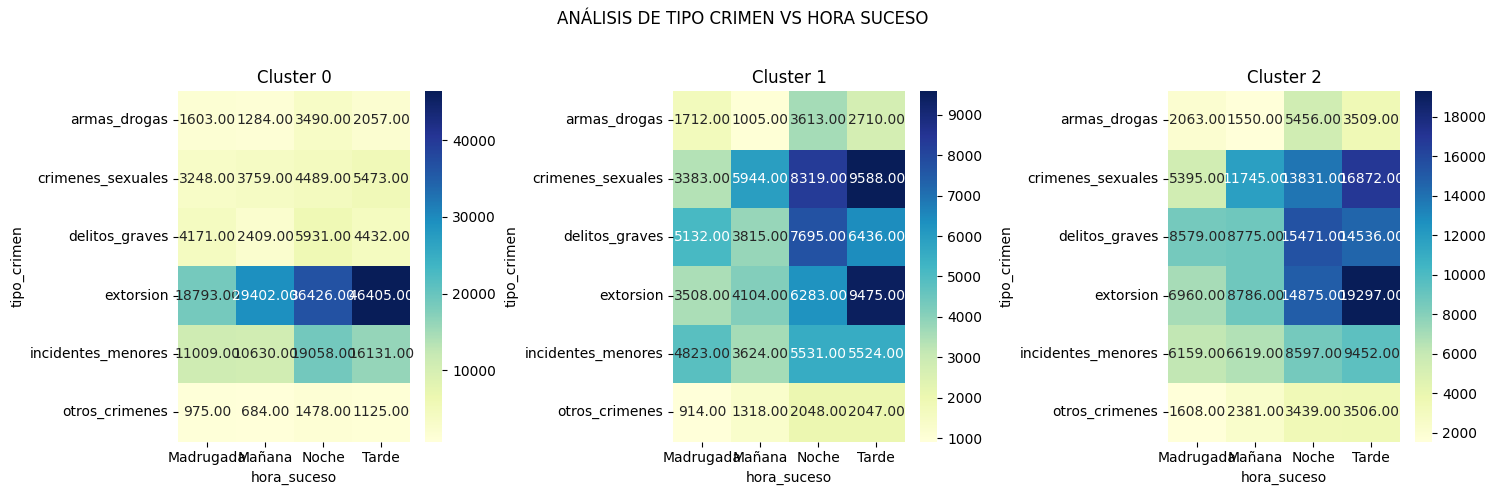

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(brooklyn_cluster0['tipo_crimen'], brooklyn_cluster0['hora_suceso'])
ct1 = pd.crosstab(brooklyn_cluster1['tipo_crimen'], brooklyn_cluster1['hora_suceso'])
ct2 = pd.crosstab(brooklyn_cluster2['tipo_crimen'], brooklyn_cluster2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

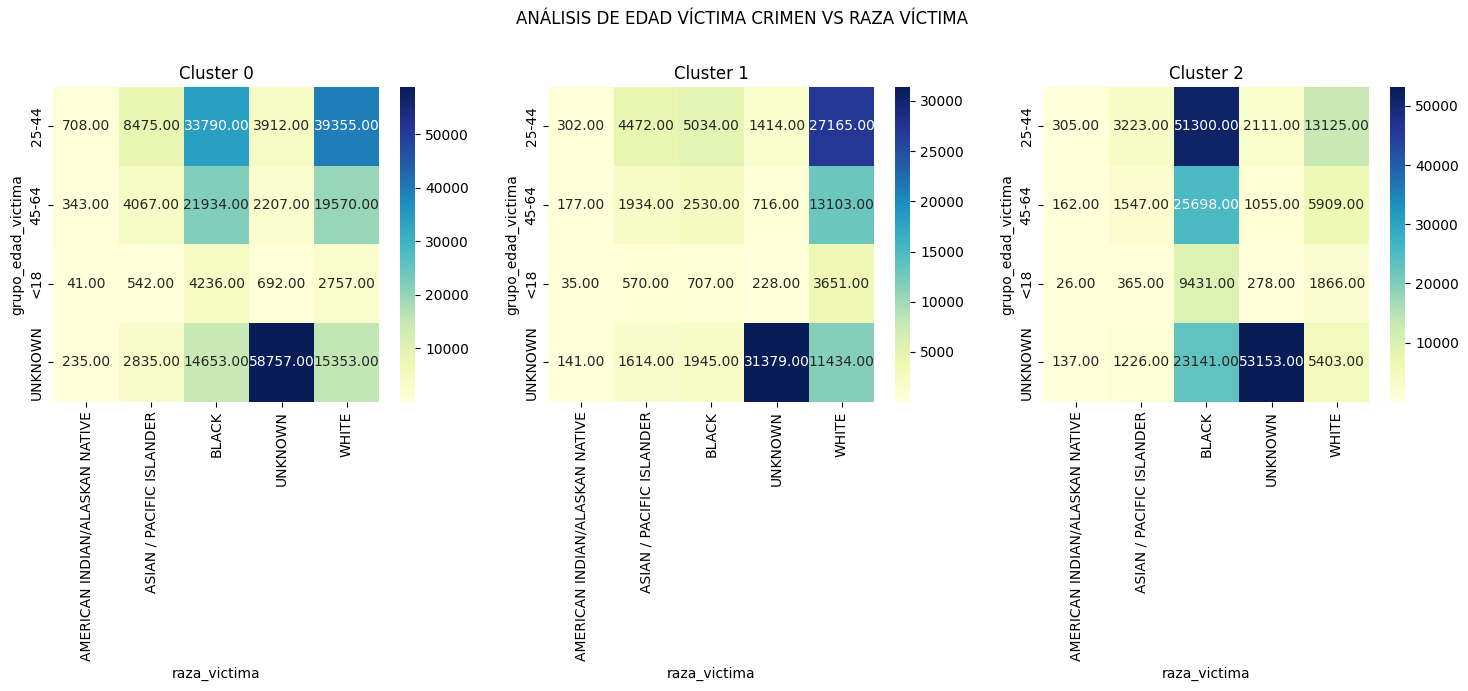

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster0['grupo_edad_victima'], brooklyn_cluster0['raza_victima'])
ct1 = pd.crosstab(brooklyn_cluster1['grupo_edad_victima'], brooklyn_cluster1['raza_victima'])
ct2 = pd.crosstab(brooklyn_cluster2['grupo_edad_victima'], brooklyn_cluster2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in brooklyn_kmeans_sin_reduccion.columns:
  if column not in ['clusters', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    display(brooklyn_kmeans_sin_reduccion.groupby(['clusters', column]).size().reset_index().rename(columns = {0:'casos'}))
    print('\n')

Variable hora_suceso:


,clusters,hora_suceso,casos
0,0,Madrugada,39799
1,0,Mañana,48168
2,0,Noche,70872
3,0,Tarde,75623
4,1,Madrugada,19472
5,1,Mañana,19810
6,1,Noche,33489
7,1,Tarde,35780
8,2,Madrugada,30764
9,2,Mañana,39856




Variable jurisdiccion_encargada:


,clusters,jurisdiccion_encargada,casos
0,0,Externas,28
1,0,Otras,1841
2,0,Policia,214239
3,0,Transito,4240
4,0,Vivienda,14114
5,1,Externas,5
6,1,Otras,639
7,1,Policia,100049
8,1,Transito,1843
9,1,Vivienda,6015




Variable grupo_edad_sospechoso:


,clusters,grupo_edad_sospechoso,casos
0,0,25-44,322
1,0,45-64,173
2,0,<18,181
3,0,UNKNOWN,233786
4,1,25-44,50186
5,1,45-64,18660
6,1,<18,4168
7,1,UNKNOWN,35537
8,2,25-44,83505
9,2,45-64,29321




Variable raza_sospechoso:


,clusters,raza_sospechoso,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,37
1,0,ASIAN / PACIFIC ISLANDER,250
2,0,BLACK,2417
3,0,UNKNOWN,230819
4,0,WHITE,939
5,1,AMERICAN INDIAN/ALASKAN NATIVE,816
6,1,ASIAN / PACIFIC ISLANDER,9516
7,1,UNKNOWN,5275
8,1,WHITE,92944
9,2,AMERICAN INDIAN/ALASKAN NATIVE,168




Variable sexo_sospechoso:


,clusters,sexo_sospechoso,casos
0,0,Desconocido,220359
1,0,Femenino,4565
2,0,Masculino,9538
3,1,Desconocido,1278
4,1,Femenino,22830
5,1,Masculino,84443
6,2,Desconocido,3296
7,2,Femenino,48318
8,2,Masculino,147847




Variable grupo_edad_victima:


,clusters,grupo_edad_victima,casos
0,0,25-44,86240
1,0,45-64,48121
2,0,<18,8268
3,0,UNKNOWN,91833
4,1,25-44,38387
5,1,45-64,18460
6,1,<18,5191
7,1,UNKNOWN,46513
8,2,25-44,70064
9,2,45-64,34371




Variable raza_victima:


,clusters,raza_victima,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,1327
1,0,ASIAN / PACIFIC ISLANDER,15919
2,0,BLACK,74613
3,0,UNKNOWN,65568
4,0,WHITE,77035
5,1,AMERICAN INDIAN/ALASKAN NATIVE,655
6,1,ASIAN / PACIFIC ISLANDER,8590
7,1,BLACK,10216
8,1,UNKNOWN,33737
9,1,WHITE,55353




Variable sexo_victima:


,clusters,sexo_victima,casos
0,0,Femenino,81531
1,0,Masculino,99462
2,0,Transgenero,53469
3,1,Femenino,45553
4,1,Masculino,33945
5,1,Transgenero,29053
6,2,Femenino,93011
7,2,Masculino,57098
8,2,Transgenero,49352




Variable tipo_crimen:


,clusters,tipo_crimen,casos
0,0,armas_drogas,8434
1,0,crimenes_sexuales,16969
2,0,delitos_graves,16943
3,0,extorsion,131026
4,0,incidentes_menores,56828
5,0,otros_crimenes,4262
6,1,armas_drogas,9040
7,1,crimenes_sexuales,27234
8,1,delitos_graves,23078
9,1,extorsion,23370




Variable lugar:


,clusters,lugar,casos
0,0,Otros,8797
1,0,diversion y turismo,29569
2,0,lugares publicos,175878
3,0,lugares solitarios,9034
4,0,necesidades diarias,11184
5,1,Otros,2904
6,1,diversion y turismo,16356
7,1,lugares publicos,81309
8,1,lugares solitarios,3642
9,1,necesidades diarias,4340




Variable dia_suceso:


,clusters,dia_suceso,casos
0,0,domingo,29931
1,0,jueves,33973
2,0,lunes,33282
3,0,martes,33654
4,0,miercoles,34124
5,0,sabado,32358
6,0,viernes,37140
7,1,domingo,15636
8,1,jueves,15645
9,1,lunes,14286




Variable estacion_suceso:


,clusters,estacion_suceso,casos
0,0,invierno,54431
1,0,otono,59999
2,0,primavera,57034
3,0,verano,62998
4,1,invierno,25215
5,1,otono,27046
6,1,primavera,27918
7,1,verano,28372
8,2,invierno,45866
9,2,otono,50116




Variable mes_suceso:


,clusters,mes_suceso,casos
0,0,abril,18468
1,0,agosto,21470
2,0,diciembre,37831
3,0,febrero,19288
4,0,julio,20323
5,0,junio,20280
6,0,marzo,16384
7,0,mayo,18286
8,0,noviembre,20387
9,0,octubre,20540


### 1.2.1 Con reducción de dimensionalidad y aplicación de KMeans.

In [ ]:
from dask_ml.decomposition import PCA

dummies = pd.get_dummies(df_brooklyn_ready_sample, dtype ='int')
# crear matriz Dask
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 

# crear objeto PCA
pca = PCA(n_components=X.shape[1])

# ajustar el modelo
pca.fit(X)

PCA(n_components=68)

In [ ]:
pca.explained_variance_ratio_[:40].sum(axis = 0)

0.973008467884551

In [ ]:
pca = PCA(n_components=40)
X_PCA =pca.fit_transform(X)
#X_PCA = X_PCA.compute() 

In [ ]:
X_PCA_ok = pd.DataFrame(X_PCA, columns = ['component'+str(column) for column in range(X_PCA.shape[1])])
X_PCA_ok.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0.789229,-1.777839,-0.734235,-0.644033,0.160488,-0.128302,0.541442,0.871940,0.465385,0.104696,-1.091511,0.166473,-0.266087,-0.365285,-0.492919,-0.516265,0.133193,-0.044535,0.141429,0.121462,-0.023515,-0.153734,-0.343942,-0.304906,0.477611,-0.282006,0.772951,0.133991,0.007203,-0.129380,0.509018,0.485641,0.155701,-0.039486,0.160746,0.055280,0.187226,0.094609,-0.107100,0.076281
1,0.737125,0.748934,-0.454123,-1.041930,-1.027448,0.150593,-0.018195,-0.928812,-0.079085,0.771516,-0.252194,0.885414,-0.445335,-0.380583,0.553960,0.274804,-0.411597,0.257861,-0.769888,-0.068849,0.155784,-0.069920,-0.881691,-0.209929,-0.268212,0.471822,-0.076691,0.139597,-0.003832,0.048767,0.066835,-0.256436,0.124296,0.211505,0.572052,-0.248507,0.088790,0.041400,-0.021632,-0.005281
2,-1.156353,-0.226708,0.497907,-0.220015,0.006497,-0.874489,-0.663051,0.183473,0.499903,-0.670232,-1.096346,0.049469,-0.154231,-0.157789,-0.424711,0.229148,0.490347,-0.062725,-0.001017,-0.706085,0.147863,0.393952,-0.053719,0.044146,0.304632,-0.357453,-0.380432,0.210245,-0.026986,-0.118990,-0.352406,-0.141910,-0.309150,-0.068049,0.384300,0.881022,-0.174244,0.218692,0.441744,-0.607213
3,-1.348260,0.689687,-0.978980,0.089756,0.109148,0.029381,-1.109993,0.258595,0.800545,0.078832,0.383166,-0.273980,-0.248723,0.248712,0.235767,0.202835,0.057060,-0.027801,0.108874,0.090051,0.076046,-0.073133,-0.050574,-0.219587,0.258309,-0.520740,0.437431,-0.210701,0.003238,0.022581,-0.265160,0.408880,-0.071594,0.406245,-0.201594,-0.448359,0.014541,0.011694,-0.001592,0.037697
4,-1.066693,0.626736,0.292124,0.489290,0.709387,-0.315949,-1.000094,-0.158522,-1.256193,-0.138460,0.126193,0.329054,0.074958,-0.548301,-0.630448,0.370592,-0.063734,-0.080531,0.084333,0.600014,-0.205253,0.517916,-0.196406,-0.171094,-0.110288,-0.155427,0.030355,0.130852,0.057339,-0.144916,-0.295387,0.035098,0.195893,-0.016142,0.313217,0.580621,-0.034019,-0.042662,-0.068607,-0.015279


Según el método del codo, cuántos cluster serían una elección óptima?

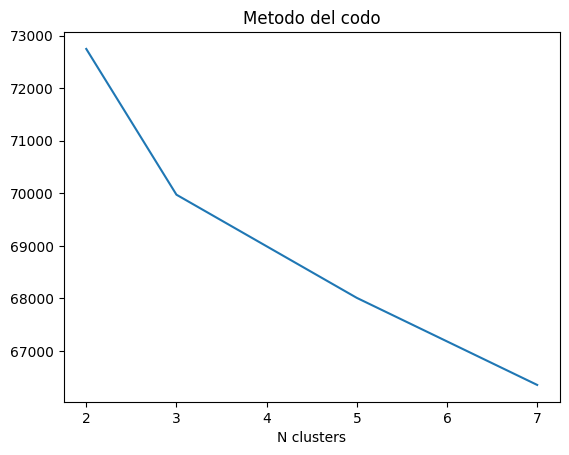

In [ ]:
n_clusters = [2, 3, 5, 7]

km = []

for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X_PCA_ok)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()

### Calinski-Harabasz Index y Silhouette Coefficient para n clusters en KMeans con PCA

In [ ]:
metrics_df_general_pca = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
n_clusters = [2,3,5,7,9]
km = []
sample = X_PCA_ok.sample(frac=0.3)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KMeans_PCA'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_pca = metrics_df_general_pca.append(metrics_df, ignore_index=True)

metrics_df_general_pca

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans_PCA,2,1008.025916,0.104982
1,KMeans_PCA,3,870.194329,0.110003
2,KMeans_PCA,5,605.064035,0.088051
3,KMeans_PCA,7,486.113974,0.077086
4,KMeans_PCA,9,397.554618,0.068022


### Centroides con KMeans y PCA y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X_PCA_ok)
centroids = kmeans.cluster_centers_ 
labels_pca = kmeans.labels_ 

In [ ]:
centroides_brooklyn_pca = pd.DataFrame(centroids, columns = X_PCA_ok.columns.tolist())
centroides_brooklyn_pca.reset_index(inplace = True, drop = False)
centroides_brooklyn_pca.rename(columns = {'index':'cluster'}, inplace =True)
centroides_brooklyn_pca

,cluster,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0,-1.079292,0.067378,0.091596,-0.008544,-0.031114,0.020084,-0.016681,0.001949,-0.008992,0.037901,0.000055,-0.009172,-0.035882,-0.034326,-0.031028,0.009544,0.032494,0.024568,-0.000456,0.009758,-0.001850,0.004205,0.032580,0.043171,0.012407,-0.004581,0.005249,-0.025350,0.001345,-0.000407,-0.001099,0.000514,0.005134,0.000971,-0.000631,-0.001970,0.000337,-0.000364,-0.005189,-0.004385
1,1,0.843580,0.516211,-0.050679,0.002958,0.025101,-0.016682,0.007498,-0.004598,-0.026222,-0.056037,-0.003754,0.029754,0.053313,0.028557,0.038000,-0.023505,-0.003110,-0.019037,0.000262,0.000969,0.005666,-0.004917,-0.011833,-0.019301,-0.026251,0.018552,0.017199,0.012722,-0.001283,0.002281,0.000784,-0.001188,-0.010674,-0.013258,0.004240,-0.003036,-0.001946,0.005626,0.003637,0.006861
2,2,0.702577,-1.498126,-0.113086,0.015070,0.018256,-0.010556,0.025023,0.006590,0.090855,0.042851,0.009452,-0.051766,-0.041236,0.017928,-0.014948,0.034805,-0.078128,-0.016416,0.000538,-0.028327,-0.009582,0.001429,-0.056058,-0.065019,0.034243,-0.035292,-0.057872,0.034632,-0.000281,-0.004753,0.000907,0.001676,0.013687,0.031321,-0.009166,0.012979,0.004083,-0.013417,0.004450,-0.005924


In [ ]:
brooklyn_kmeans_con_reduccion = df_brooklyn_ready_sample.copy()
brooklyn_kmeans_con_reduccion['clusters'] = labels_pca

### Análisis de clusters en KMeans con reducción

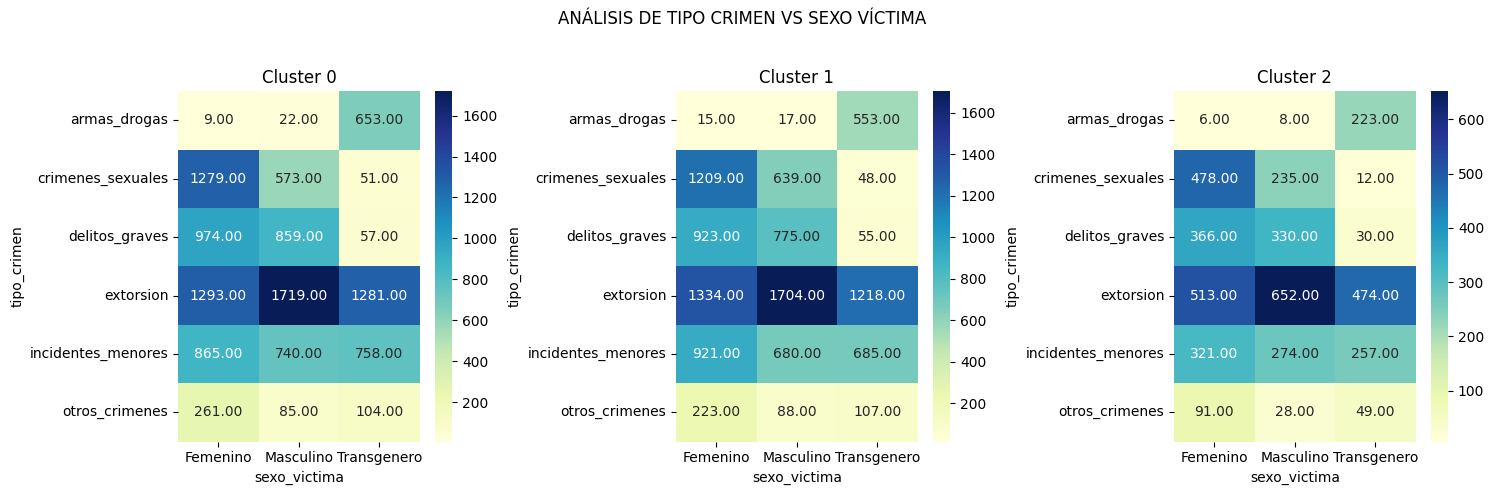

In [ ]:
brooklyn_cluster_pca0 = brooklyn_kmeans_con_reduccion[brooklyn_kmeans_con_reduccion['clusters']==0]
brooklyn_cluster_pca1 = brooklyn_kmeans_con_reduccion[brooklyn_kmeans_con_reduccion['clusters']==1]
brooklyn_cluster_pca2 = brooklyn_kmeans_con_reduccion[brooklyn_kmeans_con_reduccion['clusters']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster_pca0['tipo_crimen'], brooklyn_cluster_pca0['sexo_victima'])
ct1 = pd.crosstab(brooklyn_cluster_pca1['tipo_crimen'], brooklyn_cluster_pca1['sexo_victima'])
ct2 = pd.crosstab(brooklyn_cluster_pca2['tipo_crimen'], brooklyn_cluster_pca2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

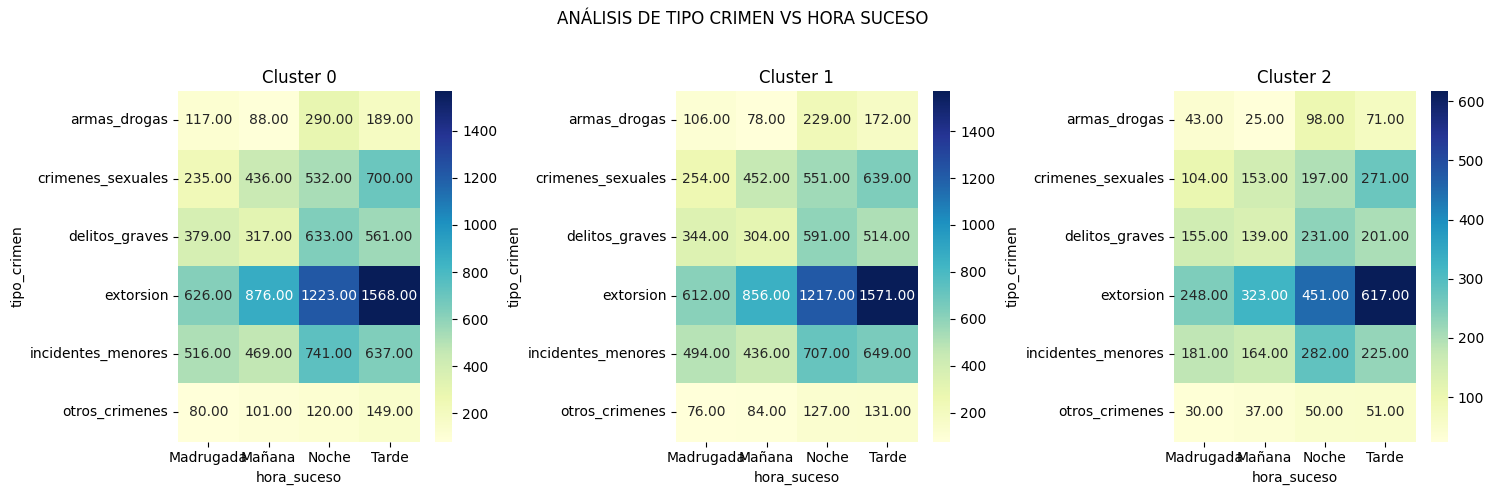

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(brooklyn_cluster_pca0['tipo_crimen'], brooklyn_cluster_pca0['hora_suceso'])
ct1 = pd.crosstab(brooklyn_cluster_pca1['tipo_crimen'], brooklyn_cluster_pca1['hora_suceso'])
ct2 = pd.crosstab(brooklyn_cluster_pca2['tipo_crimen'], brooklyn_cluster_pca2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

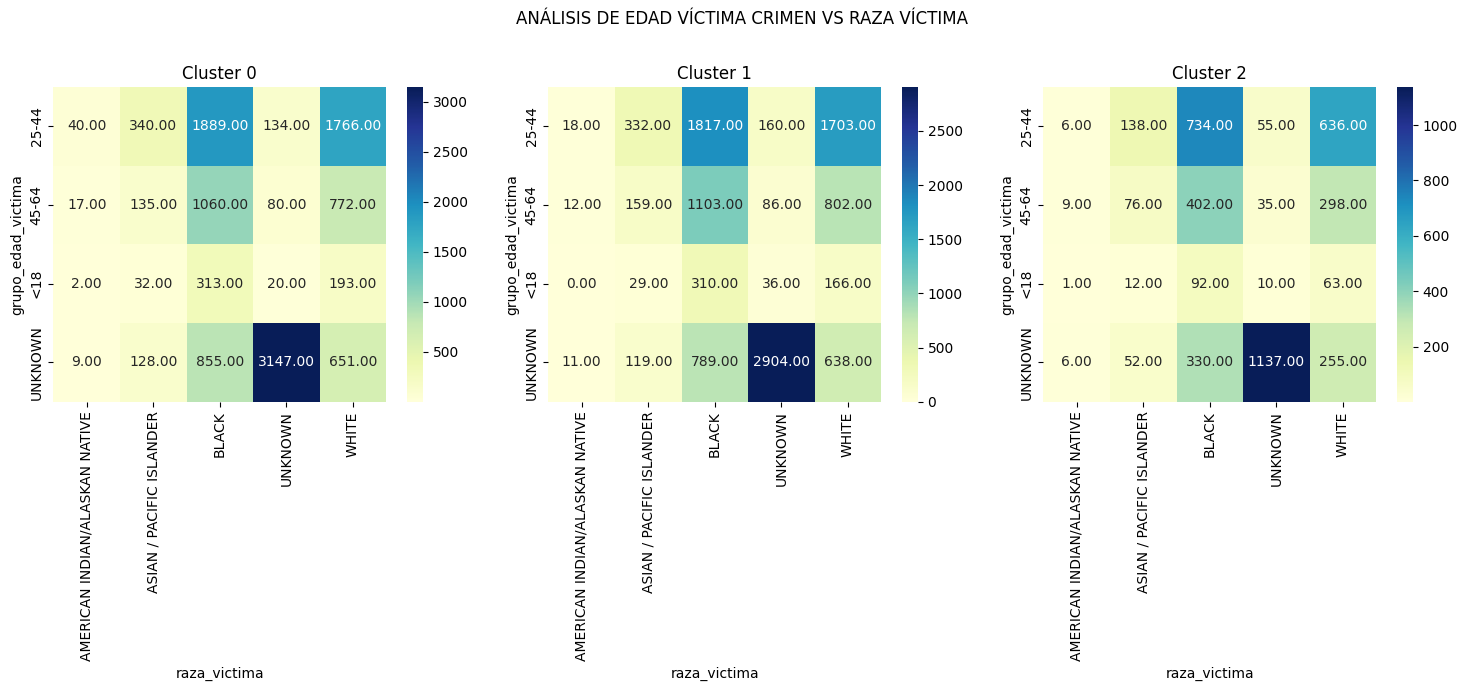

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster_pca0['grupo_edad_victima'], brooklyn_cluster_pca0['raza_victima'])
ct1 = pd.crosstab(brooklyn_cluster_pca1['grupo_edad_victima'], brooklyn_cluster_pca1['raza_victima'])
ct2 = pd.crosstab(brooklyn_cluster_pca2['grupo_edad_victima'], brooklyn_cluster_pca2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

### **2. Sin reducción de dimensionalidad y aplicación de KModes.**

Se excluyen algunas variables para el análisis

In [ ]:
df_brooklyn_ready.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)
df_brooklyn_ready_sample.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


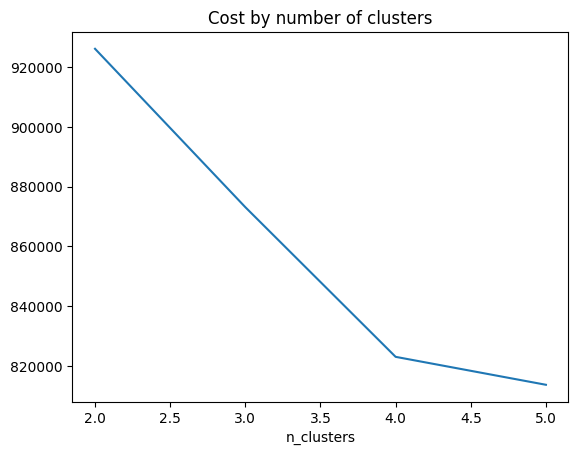

In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_brooklyn = df_brooklyn.copy()
categoricas_brooklyn_encoded = encoder.fit_transform(df_brooklyn)

cost = []
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(categoricas_brooklyn_encoded.sample(frac =0.2))
  cost.append(kmodes.cost_)

plt.title('Cost by number of clusters')
plt.xlabel('n_clusters')
plt.plot(n_clusters, cost)
plt.show()

In [ ]:
from kmodes.kmodes import KModes # se puede quitar
from sklearn.preprocessing import OrdinalEncoder # se puede quitar

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_brooklyn = df_brooklyn.copy()
categoricas_brooklyn_encoded = encoder.fit_transform(df_brooklyn)
metrics_df_general_kmodes = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])

sample = categoricas_brooklyn_encoded.sample(frac =0.5)
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(sample)
  labels = kmodes.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KModes'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_kmodes = metrics_df_general_kmodes.append(metrics_df, ignore_index=True)

metrics_df_general_kmodes

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KModes,2,1021.178904,0.014210
1,KModes,3,827.410884,-0.003920
2,KModes,4,655.639742,-0.017883
3,KModes,5,580.272777,-0.043498


In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_brooklyn = df_brooklyn_ready.copy()
categoricas_brooklyn_encoded = encoder.fit_transform(df_brooklyn_ready)

In [ ]:
kmodes = KModes(n_clusters=3, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
categoricas_brooklyn_encoded2 = categoricas_brooklyn_encoded.copy()
categoricas_brooklyn_encoded2['labels'] = kmodes.fit_predict(categoricas_brooklyn_encoded2)
categoricas_brooklyn['labels']  = categoricas_brooklyn_encoded2['labels'] 
categoricas_brooklyn.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.


,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,labels
0,Madrugada,25-44,WHITE,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,miercoles,otono,diciembre,0
1,Tarde,UNKNOWN,BLACK,Desconocido,<18,BLACK,Masculino,delitos_graves,lugares publicos,martes,invierno,febrero,0
2,Noche,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,lugares publicos,miercoles,otono,diciembre,2
3,Tarde,UNKNOWN,WHITE,Femenino,25-44,WHITE,Masculino,incidentes_menores,lugares publicos,martes,verano,agosto,1
4,Madrugada,UNKNOWN,ASIAN / PACIFIC ISLANDER,Masculino,UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares solitarios,domingo,invierno,febrero,0


### Centroides en KModes

In [ ]:
pd.DataFrame(encoder.inverse_transform(kmodes.cluster_centroids_), columns = categoricas_brooklyn_encoded.columns)

,hora_suceso,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso
0,Tarde,UNKNOWN,BLACK,Masculino,UNKNOWN,BLACK,Femenino,extorsion,lugares publicos,jueves,otono,diciembre
1,Noche,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Masculino,extorsion,lugares publicos,viernes,verano,julio
2,Mañana,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,incidentes_menores,lugares publicos,sabado,primavera,junio


### Análisis de clusters en KModes

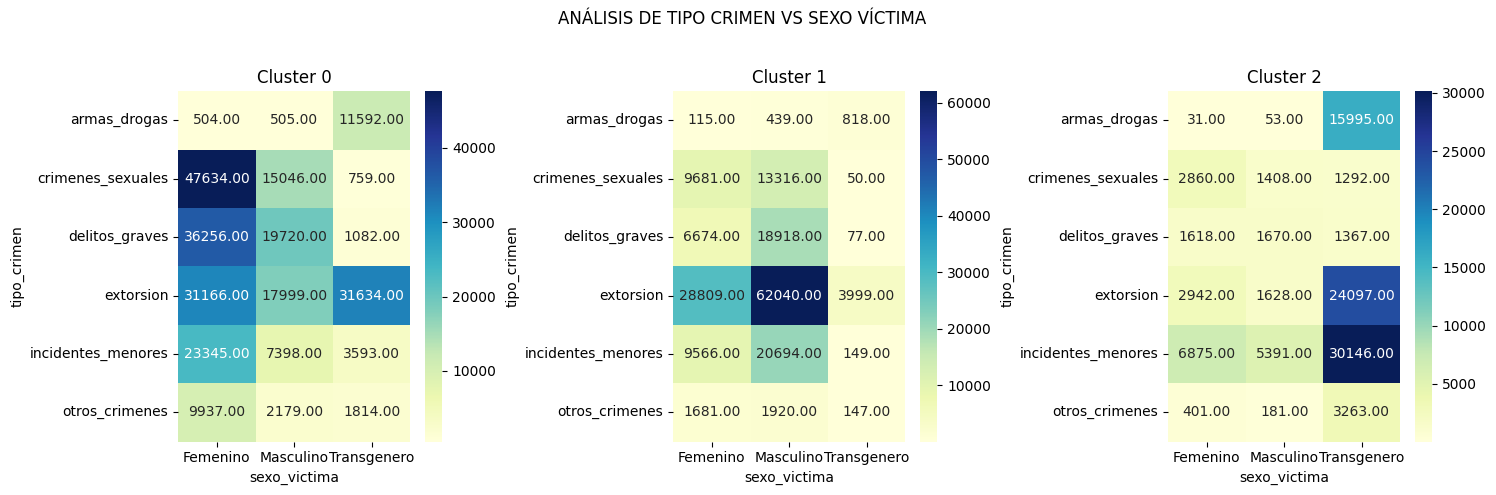

In [ ]:
brooklyn_cluster_kmodes0 = categoricas_brooklyn[categoricas_brooklyn['labels']==0]
brooklyn_cluster_kmodes1 = categoricas_brooklyn[categoricas_brooklyn['labels']==1]
brooklyn_cluster_kmodes2 = categoricas_brooklyn[categoricas_brooklyn['labels']==2]

fig, ax = plt.subplots(1,3, figsize = (15,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster_kmodes0['tipo_crimen'], brooklyn_cluster_kmodes0['sexo_victima'])
ct1 = pd.crosstab(brooklyn_cluster_kmodes1['tipo_crimen'], brooklyn_cluster_kmodes1['sexo_victima'])
ct2 = pd.crosstab(brooklyn_cluster_kmodes2['tipo_crimen'], brooklyn_cluster_kmodes2['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

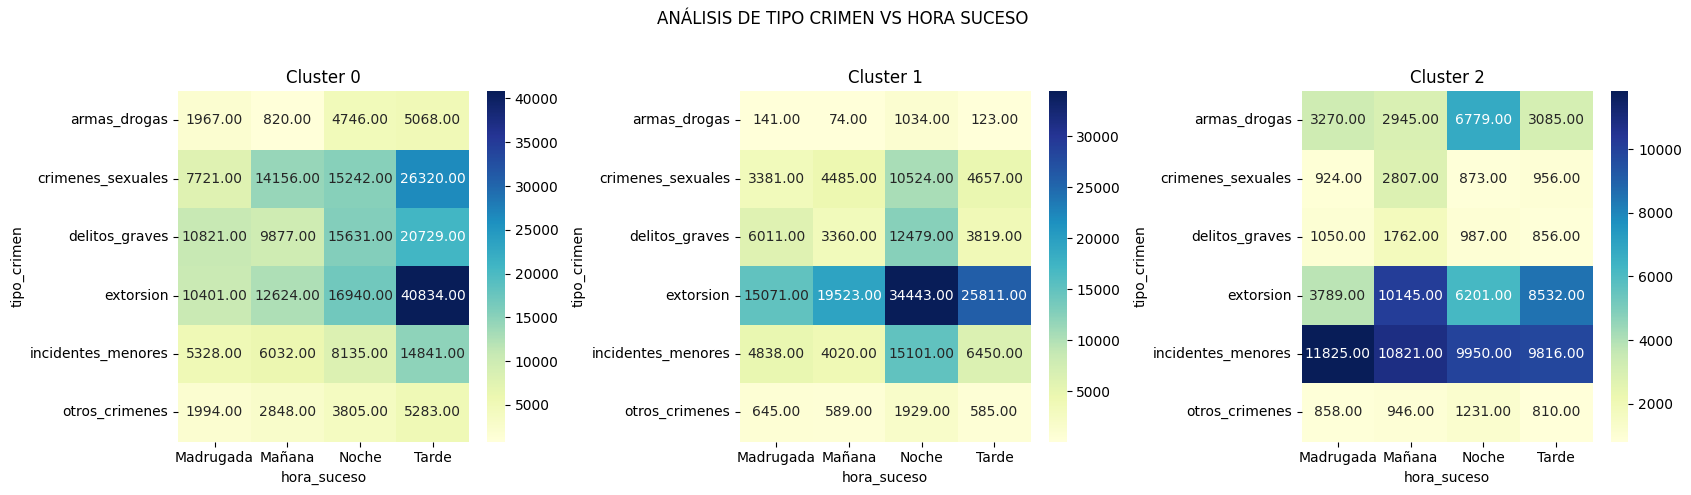

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (17,5))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(brooklyn_cluster_kmodes0['tipo_crimen'], brooklyn_cluster_kmodes0['hora_suceso'])
ct1 = pd.crosstab(brooklyn_cluster_kmodes1['tipo_crimen'], brooklyn_cluster_kmodes1['hora_suceso'])
ct2 = pd.crosstab(brooklyn_cluster_kmodes2['tipo_crimen'], brooklyn_cluster_kmodes2['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

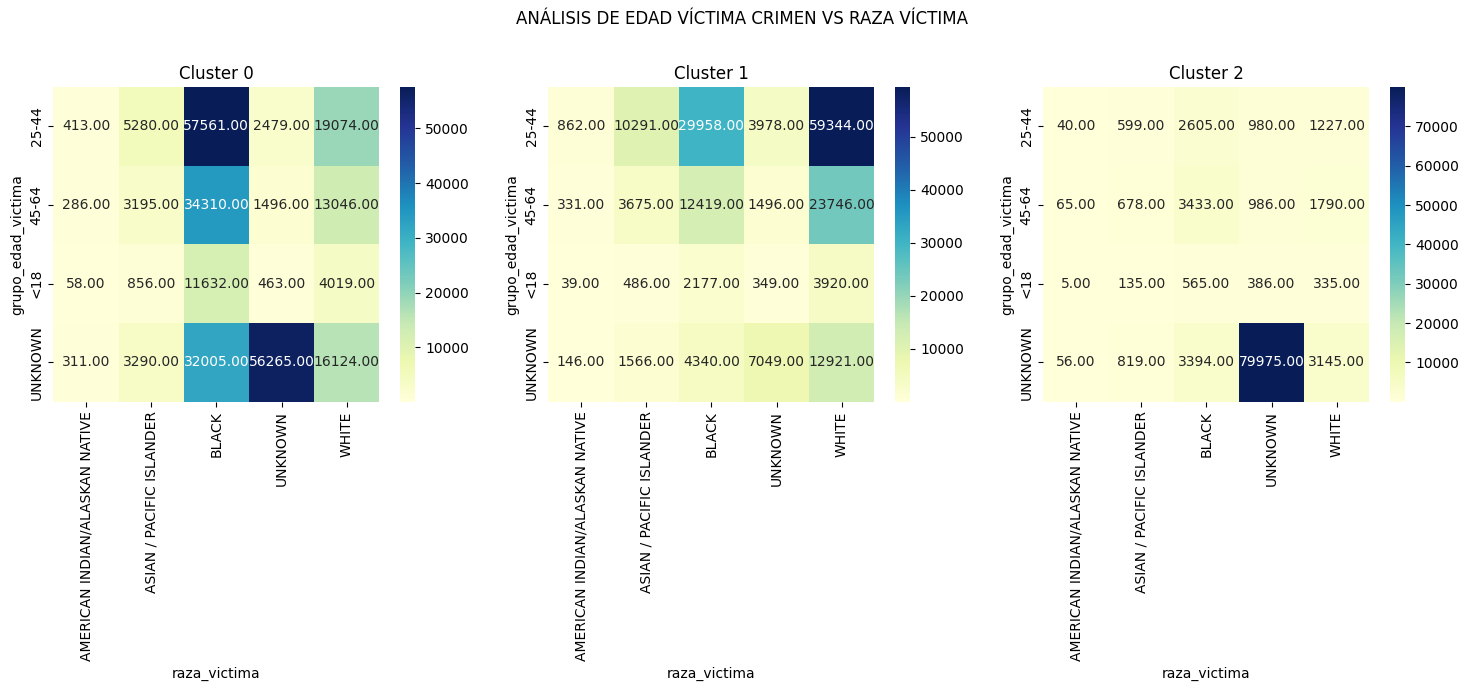

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (15,7))
fig.suptitle('ANÁLISIS DE EDAD VÍCTIMA CRIMEN VS RAZA VÍCTIMA \n')
ct0 = pd.crosstab(brooklyn_cluster_kmodes0['grupo_edad_victima'], brooklyn_cluster_kmodes0['raza_victima'])
ct1 = pd.crosstab(brooklyn_cluster_kmodes1['grupo_edad_victima'], brooklyn_cluster_kmodes1['raza_victima'])
ct2 = pd.crosstab(brooklyn_cluster_kmodes2['grupo_edad_victima'], brooklyn_cluster_kmodes2['raza_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

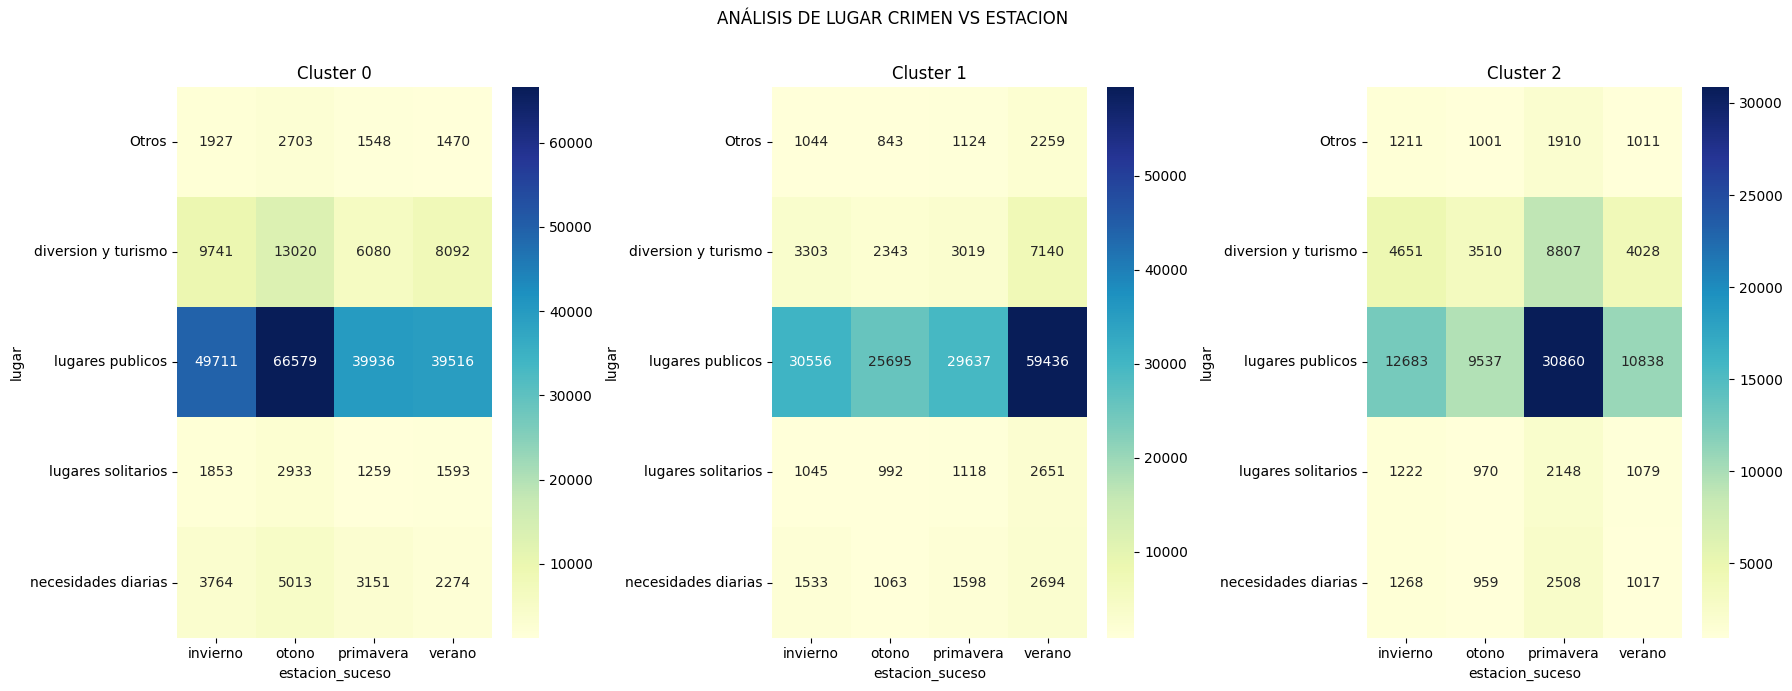

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (18,7))
fig.suptitle('ANÁLISIS DE LUGAR CRIMEN VS ESTACION \n')
ct0 = pd.crosstab(brooklyn_cluster_kmodes0['lugar'], brooklyn_cluster_kmodes0['estacion_suceso'])
ct1 = pd.crosstab(brooklyn_cluster_kmodes1['lugar'], brooklyn_cluster_kmodes1['estacion_suceso'])
ct2 = pd.crosstab(brooklyn_cluster_kmodes2['lugar'], brooklyn_cluster_kmodes2['estacion_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.0f', ax = ax[2])

ax[0].set_title('Cluster 0')
ax[1].set_title('Cluster 1')
ax[2].set_title('Cluster 2')

plt.tight_layout()
plt.show()

In [ ]:
for column in categoricas_brooklyn.columns:
  if column not in ['labels', 'latitud', 'longitud']:
    print(f"Variable {column}:")
    display(categoricas_brooklyn.groupby(['labels', column]).size().reset_index().rename(columns = {0:'casos'}))
    print('\n')

Variable hora_suceso:


,labels,hora_suceso,casos
0,0,Madrugada,38232
1,0,Mañana,46357
2,0,Noche,64499
3,0,Tarde,113075
4,1,Madrugada,30087
5,1,Mañana,32051
6,1,Noche,75510
7,1,Tarde,41445
8,2,Madrugada,21716
9,2,Mañana,29426




Variable grupo_edad_sospechoso:


,labels,grupo_edad_sospechoso,casos
0,0,25-44,95118
1,0,45-64,35491
2,0,<18,12555
3,0,UNKNOWN,118999
4,1,25-44,21307
5,1,45-64,6971
6,1,<18,2130
7,1,UNKNOWN,148685
8,2,25-44,17588
9,2,45-64,5692




Variable raza_sospechoso:


,labels,raza_sospechoso,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,627
1,0,ASIAN / PACIFIC ISLANDER,6300
2,0,BLACK,165057
3,0,UNKNOWN,39816
4,0,WHITE,50363
5,1,AMERICAN INDIAN/ALASKAN NATIVE,254
6,1,ASIAN / PACIFIC ISLANDER,2486
7,1,BLACK,15907
8,1,UNKNOWN,133289
9,1,WHITE,27157




Variable sexo_sospechoso:


,labels,sexo_sospechoso,casos
0,0,Desconocido,32680
1,0,Femenino,49874
2,0,Masculino,179609
3,1,Desconocido,127936
4,1,Femenino,16563
5,1,Masculino,34594
6,2,Desconocido,64317
7,2,Femenino,9276
8,2,Masculino,27625




Variable grupo_edad_victima:


,labels,grupo_edad_victima,casos
0,0,25-44,84807
1,0,45-64,52333
2,0,<18,17028
3,0,UNKNOWN,107995
4,1,25-44,104433
5,1,45-64,41667
6,1,<18,6971
7,1,UNKNOWN,26022
8,2,25-44,5451
9,2,45-64,6952




Variable raza_victima:


,labels,raza_victima,casos
0,0,AMERICAN INDIAN/ALASKAN NATIVE,1068
1,0,ASIAN / PACIFIC ISLANDER,12621
2,0,BLACK,135508
3,0,UNKNOWN,60703
4,0,WHITE,52263
5,1,AMERICAN INDIAN/ALASKAN NATIVE,1378
6,1,ASIAN / PACIFIC ISLANDER,16018
7,1,BLACK,48894
8,1,UNKNOWN,12872
9,1,WHITE,99931




Variable sexo_victima:


,labels,sexo_victima,casos
0,0,Femenino,148842
1,0,Masculino,62847
2,0,Transgenero,50474
3,1,Femenino,56526
4,1,Masculino,117327
5,1,Transgenero,5240
6,2,Femenino,14727
7,2,Masculino,10331
8,2,Transgenero,76160




Variable tipo_crimen:


,labels,tipo_crimen,casos
0,0,armas_drogas,12601
1,0,crimenes_sexuales,63439
2,0,delitos_graves,57058
3,0,extorsion,80799
4,0,incidentes_menores,34336
5,0,otros_crimenes,13930
6,1,armas_drogas,1372
7,1,crimenes_sexuales,23047
8,1,delitos_graves,25669
9,1,extorsion,94848




Variable lugar:


,labels,lugar,casos
0,0,Otros,7648
1,0,diversion y turismo,36933
2,0,lugares publicos,195742
3,0,lugares solitarios,7638
4,0,necesidades diarias,14202
5,1,Otros,5270
6,1,diversion y turismo,15805
7,1,lugares publicos,145324
8,1,lugares solitarios,5806
9,1,necesidades diarias,6888




Variable dia_suceso:


,labels,dia_suceso,casos
0,0,domingo,35419
1,0,jueves,48177
2,0,lunes,37133
3,0,martes,38154
4,0,miercoles,38942
5,0,sabado,31823
6,0,viernes,32515
7,1,domingo,24890
8,1,jueves,18529
9,1,lunes,25369




Variable estacion_suceso:


,labels,estacion_suceso,casos
0,0,invierno,66996
1,0,otono,90248
2,0,primavera,51974
3,0,verano,52945
4,1,invierno,37481
5,1,otono,30936
6,1,primavera,36496
7,1,verano,74180
8,2,invierno,21035
9,2,otono,15977




Variable mes_suceso:


,labels,mes_suceso,casos
0,0,abril,18244
1,0,agosto,19435
2,0,diciembre,58246
3,0,febrero,21422
4,0,julio,14019
5,0,junio,15827
6,0,marzo,19348
7,0,mayo,17903
8,0,noviembre,29259
9,0,octubre,28969
